In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import skimage.transform as skt
import hyperspy.api as hys
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
import tkinter.filedialog as tkf
from ipywidgets import interact
import ipywidgets as widgets

In [2]:
def warp_scale(spectrum):
    spectrum = spectrum.clip(min=0.0)
    min_val = np.min(spectrum)
    
    rescaled = spectrum - min_val
    
    if np.max(rescaled) != 0:
        rescaled = rescaled / np.max(rescaled)
    
    return rescaled

In [3]:
dm_files = tkf.askopenfilenames()
print(len(dm_files))
print(dm_files)

3
('E:/data_temporary/data_processed/20191111_pdf_normalized/BSET01_02_scan_x256_y256_radial_var_radial.hdf5', 'E:/data_temporary/data_processed/20191111_pdf_normalized/BSET02_02_scan_x256_y256_radial_var_radial.hdf5', 'E:/data_temporary/data_processed/20191111_pdf_normalized/BSET03_02_scan_x256_y256_radial_var_radial.hdf5')


In [ ]:
dm_files = list(dm_files)
dm_files.extend(tkf.askopenfilenames())
print(len(dm_files))
print(dm_files)

In [ ]:
dm_files = list(dm_files)
dm_files.extend(tkf.askopenfilenames())
print(len(dm_files))
print(dm_files)

In [4]:
data_storage = []
data_shape = []
for i, adr in enumerate(dm_files):
    temp = hys.load(adr)
    temp = temp.data
    print(temp.shape)
    
    data_shape.append(temp.shape)
    data_storage.append(temp)

(251, 45, 91)
(254, 52, 91)
(252, 66, 91)


In [6]:
cut_point = 21
num_img = len(data_storage)

data_shape = np.asarray(data_shape)
print(data_shape)
#s_dim = np.min(data_shape[:, 2])
s_dim = 41
dataset = []
data_shape_new = []

cluster_size_y = 1
cluster_size_x = 1
stride_y = 1
stride_x = 1

for img in data_storage:
    height = len(range(0, img.shape[0]-cluster_size_y+1, stride_y))
    width = len(range(0, img.shape[1]-cluster_size_x+1, stride_x))
    data_shape_new.append([height, width])
    temp= []
    for i in range(0, img.shape[0]-cluster_size_y+1, stride_y):
        for j in range(0, img.shape[1]-cluster_size_x+1, stride_x):
            #temp_sum = warp_scale(np.sum(img[i:i+cluster_size_y, j:j+cluster_size_x, cut_point:], axis=(0, 1)))
            temp_sum = np.sum(img[i:i+cluster_size_y, j:j+cluster_size_x, cut_point:s_dim], axis=(0, 1))
            temp.append(temp_sum)
    temp = np.asarray(temp).reshape(height, width, s_dim-cut_point)
    dataset.append(temp)

s_dim = s_dim - cut_point
data_shape_new = np.asarray(data_shape_new)
print(data_shape_new)
print(s_dim)

[[251  45  91]
 [254  52  91]
 [252  66  91]]
[[251  45]
 [254  52]
 [252  66]]
20


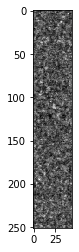

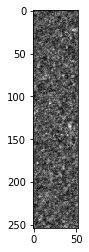

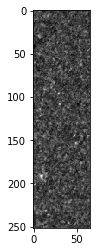

In [7]:
%matplotlib inline
img_storage = []

for i in range(num_img):
    img_storage.append(np.sum(data_storage[i], axis=2))
            
for i in range(num_img):
    plt.imshow(img_storage[i])
    plt.show()

In [8]:
def colortable(colors, title, sort_colors=True, emptycols=0):
    
    by_hsv = ((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                    for name, color in colors.items())
    if sort_colors is True:
        by_hsv = sorted(by_hsv)
    names = [name for hsv, name in by_hsv]
    
    return names

color_name = colortable(mcolors.CSS4_COLORS, "CSS Colors")
num_color = len(color_name)
print(len(color_name))

ri = np.random.choice(num_color, num_color, replace=False)
ri = np.sort(ri)
print(ri)
color_cand_4 = {}
for i in range(num_color):
    color_cand_4[i] = color_name[ri[i]]

148
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147]


In [9]:
# only one color
class_group = []
color_group = []
for i in range(num_img):
    for j in range(data_shape_new[i, 0]):
        for k in range(data_shape_new[i, 1]):
            color_group.append("red")

In [10]:
dataset_input = []
for i in range(num_img):
    dataset_input.extend(dataset[i].clip(min=0.0).reshape(-1, s_dim).tolist())
    
dataset_input = np.asarray(dataset_input)
print(dataset_input.shape)

(41135, 20)


In [11]:
def nmf(data_set, n_comp=5, vis_comp=False, projection=False, inverse=False, initialize="nndsvda"):
    print("Doing NMF...")

    nmf = NMF(n_components=n_comp, init=initialize, solver="mu", max_iter=1000, random_state=56, verbose=True)

    reduced_projection = nmf.fit_transform(data_set)    

    return nmf.components_, reduced_projection

In [ ]:
%matplotlib inline
num_comp = 3
comp_vectors, projections = nmf(dataset_input, n_comp=num_comp, 
                                             vis_comp=False, projection=False, initialize="nndsvda")
plt.show()

In [ ]:
%matplotlib inline
print(comp_vectors.shape)
fig, ax = plt.subplots(num_comp, 1, figsize=(5, 8))
for i, a in enumerate(ax):
    a.plot(comp_vectors[i], "k-", c="black")
    a.grid()
    #a.set_title("%d component"%(i+1), fontsize=15)
fig.tight_layout()
plt.show()

In [ ]:
plt.close(fig)

In [13]:
def tSNE(data_set, n_comp=2, ppx=30, eeg=12.0, lr=200.0, niter=1000):
    print("Doing t-SNE...")
    
    tsne = TSNE(n_components=n_comp, perplexity=ppx, early_exaggeration=eeg, learning_rate=lr, 
                init="random", n_iter=niter, verbose=2, random_state=56)
    
    tsne.fit_transform(data_set)
    
    return tsne.embedding_

In [17]:
n_comp_tsne = 2
embedding = tSNE(dataset_input, n_comp=n_comp_tsne, ppx=50, eeg=10.0, lr=200.0, niter=1000)

Doing t-SNE...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 41135 samples in 0.061s...
[t-SNE] Computed neighbors for 41135 samples in 55.346s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41135
[t-SNE] Computed conditional probabilities for sample 2000 / 41135
[t-SNE] Computed conditional probabilities for sample 3000 / 41135
[t-SNE] Computed conditional probabilities for sample 4000 / 41135
[t-SNE] Computed conditional probabilities for sample 5000 / 41135
[t-SNE] Computed conditional probabilities for sample 6000 / 41135
[t-SNE] Computed conditional probabilities for sample 7000 / 41135
[t-SNE] Computed conditional probabilities for sample 8000 / 41135
[t-SNE] Computed conditional probabilities for sample 9000 / 41135
[t-SNE] Computed conditional probabilities for sample 10000 / 41135
[t-SNE] Computed conditional probabilities for sample 11000 / 41135
[t-SNE] Computed conditional probabilities for sample 12000 / 41135
[t-SNE] Computed conditional prob

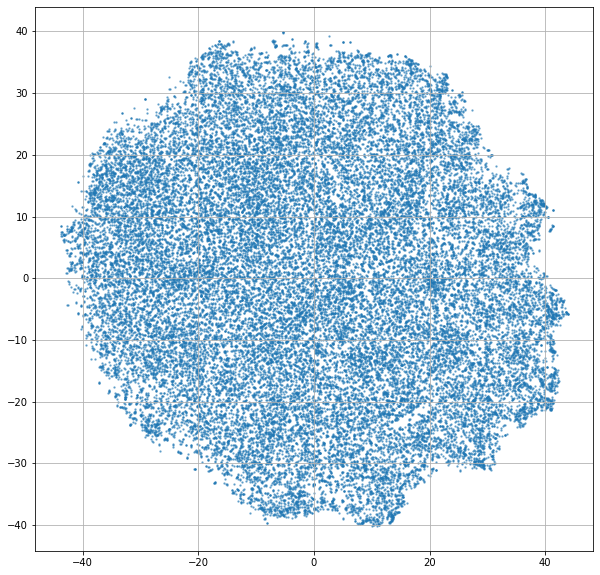

In [18]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=2, alpha=0.5)
plt.grid()
plt.show()

In [ ]:
num_comp = n_comp_tsne
projections = embedding

In [ ]:
projections_copy = projections.copy()
print(projections_copy.shape)
projection_reshape = []
for i in range(num_img):
    temp = projections_copy[:int(data_shape_new[i, 0]*data_shape_new[i, 1]), :]
    print(temp.shape)
    projections_copy = np.delete(projections_copy, range(int(data_shape_new[i, 0]*data_shape_new[i, 1])), axis=0)
    print(projections_copy.shape)
    temp = np.reshape(temp, (data_shape_new[i, 0], data_shape_new[i, 1], -1))
    print(temp.shape)
    projection_reshape.append(temp)

In [ ]:
%matplotlib qt
# for many images
fig1, ax1 = plt.subplots(1, num_img, figsize=(8, 6))
    
def map_selector(comp):
    for i, axs in enumerate(ax1):
        axs.cla()
        axs.imshow(projection_reshape[i][:, :, comp], cmap="gray")
        axs.set_title("component %d map"%(comp+1), fontsize=10)
        axs.axis("off")
    fig1.canvas.draw()
    fig1.tight_layout()
    
interact(map_selector, comp=widgets.IntSlider(min=0, max=num_comp-1, step=1, value=0))
fig1.show()

In [ ]:
plt.close(fig1)

In [ ]:
%matplotlib qt
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 10))

def projection(c1, c2):
    ax2.cla()
    ax2.scatter(projections[:, c1], projections[:, c2], s=5, c=color_group, alpha=0.5)
    ax2.grid()
    ax2.set_xlabel("component %d"%(c1+1), fontsize=20)
    ax2.set_ylabel("component %d"%(c2+1), fontsize=20)
    fig2.canvas.draw()
    fig2.tight_layout()

x_widget = widgets.IntSlider(min=0, max=num_comp-1, step=1, value=0)
y_widget = widgets.IntSlider(min=0, max=num_comp-1, step=1, value=1)

interact(projection, c1=x_widget, c2=y_widget)
fig2.show()

In [ ]:
plt.close(fig2)

In [ ]:
%matplotlib qt
# for many images
from matplotlib.widgets import EllipseSelector

comp_v1 = 0
comp_v2 = 2

fig3, ax3 = plt.subplots(1, 3, figsize=(20, 8))
ax3[0].scatter(projections[:, comp_v1], projections[:, comp_v2], s=3.0, alpha=0.5, c=color_group)
ax3[0].tick_params(axis="both", labelsize=15)
ax3[0].grid()
ax3[1].scatter(projections[:, comp_v1], projections[:, comp_v2], s=3.0, alpha=0.5, cmap="Set1")
ax3[1].tick_params(axis="both", labelsize=15)
ax3[1].grid()
ax3[2].plot(np.zeros(s_dim))
ax3[2].tick_params(axis="both", labelsize=15)
ax3[2].grid()

fig4, ax4 = plt.subplots(2, num_img, figsize=(10, 5))

cluster = []

for i in range(num_img):
    ax4[0][i].imshow(img_storage[i], cmap="gray")
    ax4[0][i].axis("off")
    ax4[1][i].imshow(img_storage[i], cmap="gray")
    ax4[1][i].axis("off")

def ellipse_equation(cx, cy, a, b, x, y):
    return ((x-cx)/a)**2 + ((y-cy)/b)**2

def onselect(eclick, erelease):
    center_x = (erelease.xdata + eclick.xdata) / 2.0
    center_y = (erelease.ydata + eclick.ydata) / 2.0
    a = abs((erelease.xdata - eclick.xdata) / 2.0)
    b = abs((erelease.ydata - eclick.ydata) / 2.0)
    #print(center_x)
    #print(center_y)
    #print(a)
    #print(b)
    
    temp = []
    spectra_sum = np.zeros(s_dim)
    
    color = []
    for i in range(len(dataset_input)):
        if ellipse_equation(center_x, center_y, a, b, projections[i, comp_v1], projections[i, comp_v2]) <= 1:
            #print("wow")
            temp.append(1)
            spectra_sum += dataset_input[i]
            color.append(1)
        else:
            temp.append(0)
            color.append(0)
            
    ax3[1].cla()
    ax3[1].scatter(projections[:, comp_v1], projections[:, comp_v2], s=3.0, alpha=0.5, c=color, cmap="Set1")
    ax3[1].grid()
    
    ax3[2].cla()
    ax3[2].plot(warp_scale(spectra_sum))
    ax3[2].grid()
    
    temp = np.asarray(temp)
    #print(temp.shape)
    selected = []
    for i in range(num_img):
        selected_temp = temp[:int(data_shape_new[i, 0]*data_shape_new[i, 1])]
        temp = np.delete(temp, range(int(data_shape_new[i, 0]*data_shape_new[i, 1])))
        selected_temp = np.reshape(selected_temp, data_shape_new[i])
        selected.append(selected_temp)
    
    for i in range(num_img):
        ax4[1][i].imshow(selected[i], cmap="Set1")
        ax4[1][i].axis("off")
        
    fig3.canvas.draw()
    fig4.canvas.draw()
    fig3.tight_layout()
    fig4.tight_layout()
    
    cluster.append(selected)
        
ep = EllipseSelector(ax3[0], onselect, drawtype="line")
plt.show()

In [ ]:
plt.close(fig3)
plt.close(fig4)
print(len(cluster))

In [ ]:
num_sel = 2
selected = []
for i in range(num_sel):
    selected.append(cluster[-(i+1)])
    
selected.reverse()

In [ ]:
# compare the reconstructed signals by clusters

comp_array = np.arange(num_comp)
#comp_array = np.array([1, 2])

reconstructed = np.dot(projections[:, comp_array], comp_vectors[comp_array])
print(reconstructed.shape)
reconstructed_copy = reconstructed.copy()
reconstructed_reshape = []

for i in range(num_img):
    temp = reconstructed_copy[:int(data_shape_new[i, 0]*data_shape_new[i, 1]), :]
    print(temp.shape)
    reconstructed_copy = np.delete(reconstructed_copy, range(int(data_shape_new[i, 0]*data_shape_new[i, 1])), axis=0)
    print(projections_copy.shape)
    temp = np.reshape(temp, (data_shape_new[i, 0], data_shape_new[i, 1], -1))
    print(temp.shape)
    reconstructed_reshape.append(temp)   

#for i in range(num_img):
#    for j in range(data_shape_new[i, 0]):
#        for k in range(data_shape_new[i, 1]):
#            reconstructed_reshape[i][j, k] = warp_scale(reconstructed_reshape[i][j, k])

In [ ]:
# compare the original input signals by clusters

reconstructed_reshape = []
dataset_input_copy = dataset_input.copy()
for i in range(num_img):
    temp = dataset_input_copy[:int(data_shape_new[i, 0]*data_shape_new[i, 1]), :]
    dataset_input_copy = np.delete(dataset_input_copy, range(int(data_shape_new[i, 0]*data_shape_new[i, 1])), axis=0)
    temp = np.reshape(temp, (data_shape_new[i, 0], data_shape_new[i, 1], -1))
    reconstructed_reshape.append(temp)
    
#for i in range(num_img):
#    for j in range(data_shape_new[i, 0]):
#        for k in range(data_shape_new[i, 1]):
#            reconstructed_reshape[i][j, k] = warp_scale(reconstructed_reshape[i][j, k])

In [ ]:
# cluster vs. cluster in all individual images
%matplotlib inline
lines = np.zeros((num_img, num_sel, s_dim))
sel_num = np.zeros((num_img, num_sel))

for h in range(num_img):
    for i in range(num_sel):
        for j in range(data_shape_new[h, 0]):
            for k in range(data_shape_new[h, 1]):
                if selected[i][h][j, k] == 1:
                    sel_num[h, i] += 1
                    lines[h, i] += reconstructed_reshape[h][j, k]

print(sel_num) 
#for h in range(num_img):            
#    for i in range(num_sel):
#        lines[h, i] = warp_scale(lines[h, i])

for h in range(num_img):
    for i in range(num_sel):
        lines[h, i] /= sel_num[h, i]
            
fig5, ax5 = plt.subplots(1, 1, figsize=(10, 10))

for j in range(num_img):
    for i in range(num_sel):
        ax5.plot((lines[j, i]), label="image %d - line %d"%(j+1, i+1), c=color_cand_4[(2*i+j+2)*17])
        
ax5.grid()
ax5.set_facecolor("black")
fig5.legend()
fig5.tight_layout()
plt.show()

In [ ]:
plt.close(fig5)

In [ ]:
# cluster vs. cluster
%matplotlib inline
lines = np.zeros((num_sel, s_dim))
sel_num = np.zeros(num_sel)

for h in range(num_img):
    for i in range(num_sel):
        for j in range(data_shape_new[h, 0]):
            for k in range(data_shape_new[h, 1]):
                if selected[i][h][j, k] == 1:
                    sel_num[i] += 1
                    lines[i] += reconstructed_reshape[h][j, k]
print(sel_num)
lines_nor = np.zeros((num_sel, s_dim))
for i in range(num_sel):
    lines_nor[i] = warp_scale(lines[i])

for i in range(num_sel):
    lines[i] /= sel_num[i]
            
fig11, ax11 = plt.subplots(2, 1, figsize=(10, 20))

for i in range(num_sel):
    ax11[0].plot((lines[i]), label="line %d"%(i+1), c=color_cand_4[(i+1)*25])
    ax11[1].plot((lines_nor[i]), label="line %d"%(i+1), c=color_cand_4[(i+1)*25])
ax11[0].grid()
ax11[0].set_facecolor("black")
ax11[0].legend()
ax11[1].grid()
ax11[1].set_facecolor("black")
ax11[1].legend()
fig11.tight_layout()

plt.show()

In [ ]:
plt.close(fig11)

In [ ]:
# cluster vs. cluster within an image
%matplotlib qt
lines = np.zeros((num_img, num_sel, s_dim))
sel_num = np.zeros((num_img, num_sel))

for h in range(num_img):
    for i in range(num_sel):
        for j in range(data_shape_new[h, 0]):
            for k in range(data_shape_new[h, 1]):
                if selected[i][h][j, k] == 1:
                    sel_num[h, i] += 1
                    lines[h, i] += reconstructed_reshape[h][j, k]

print(sel_num) 
#for h in range(num_img):            
#    for i in range(num_sel):
#        lines[h, i] = warp_scale(lines[h, i])

for h in range(num_img):
    for i in range(num_sel):
        lines[h, i] /= sel_num[h, i]
            
fig6, ax6 = plt.subplots(1, 1, figsize=(10, 10))

def img_selector(img_n):
    ax6.cla()
    for i in range(num_sel):
        ax6.plot((lines[img_n, i]), label="line %d"%(i+1), c=color_cand_4[np.random.randint(len(color_cand_4))])
    ax6.grid()
    ax6.set_facecolor("black")
    fig6.canvas.draw()
    fig6.legend()
    fig6.tight_layout()
    
interact(img_selector, img_n=widgets.IntSlider(min=0, max=num_img-1, step=1, value=0))
plt.show()

In [ ]:
# image vs. image depending on the component
%matplotlib qt
lines = np.zeros((num_img, num_sel, s_dim))
sel_num = np.zeros((num_img, num_sel))

for h in range(num_img):
    for i in range(num_sel):
        for j in range(data_shape_new[h, 0]):
            for k in range(data_shape_new[h, 1]):
                if selected[i][h][j, k] == 1:
                    sel_num[h, i] += 1
                    lines[h, i] += reconstructed_reshape[h][j, k]

print(sel_num) 
#for h in range(num_img):            
#    for i in range(num_sel):
#        lines[h, i] = warp_scale(lines[h, i])

for h in range(num_img):
    for i in range(num_sel):
        lines[h, i] /= sel_num[h, i]

#for h in range(num_img):
#    for i in range(num_sel):
#        lines[h, i] /= data_shape_new[h][0]*data_shape_new[h][1]
        
for h in range(num_img):
    lines[h] /= np.max(lines[h])
            
fig6, ax6 = plt.subplots(1, 1, figsize=(10, 10))

def comp_selector(n_sel):
    ax6.cla()
    color = []
    for i in range(num_img):
        ax6.plot((lines[i, n_sel]), label="image %d"%(i+1), c=color_cand_4[(i+1)*25])
    ax6.grid()
    ax6.set_facecolor("black")
    fig6.canvas.draw()
    fig6.legend()
    fig6.tight_layout()
    
interact(comp_selector, n_sel=widgets.IntSlider(min=0, max=num_sel-1, step=1, value=0))
plt.show()

In [ ]:
# image vs. image depending on the component
%matplotlib qt
lines = np.zeros((num_img, num_sel, s_dim))
sel_num = np.zeros((num_img, num_sel))

for h in range(num_img):
    for i in range(num_sel):
        for j in range(data_shape_new[h, 0]):
            for k in range(data_shape_new[h, 1]):
                if selected[i][h][j, k] == 1:
                    sel_num[h, i] += 1
                    lines[h, i] += reconstructed_reshape[h][j, k]

for h in range(num_img):
    sel_num[h] /= data_shape_new[h][0]*data_shape_new[h][1]
        
print(sel_num*100)

In [ ]:
for i in range(num_img):
    temp = hys.signals.Signal2D(reconstructed[i])
    temp_dm = hys.signals.Signal2D(np.rollaxis(np.rollaxis(reconstructed[i], 0, 3), 0, 3))
    temp.save(dm_files[i][:-5]+"_nmf_reconstructed.hdf5")
    temp_dm.save(dm_files[i][:-5]+"_nmf_reconstructed_dm_import.hdf5")

In [ ]:
print(projections[0, 0])
print(projections[0, 1])
X = np.stack((projections[:, 1], projections[:, 2]), axis=1)
print(X.shape)
print(X[0])

In [ ]:
# clustering using k-means
from sklearn.cluster import KMeans

k_cluster = KMeans(n_clusters=5, n_init=100, random_state=34).fit_predict(X)

fig = plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=k_cluster, cmap="Accent")
plt.show()

In [ ]:
print(k_cluster.shape)
img_restored = np.reshape(k_cluster, (2, 69, 69))
print(img_restored[0].shape)

plt.imshow(img_restored[0], cmap="Accent")
plt.show()

In [ ]:
%matplotlib nbagg
# clustering using DBSCAN (Density-based Spatial Clustering of Applications with Noise)
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.01, min_samples=50).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
print(type(labels))
print(labels.shape)
#print(labels[:500])
img_restored = np.reshape(labels, (2, 69, 69))

In [ ]:
plt.imshow(img_restored[0], cmap="Accent")
plt.show()

In [ ]:
%matplotlib nbagg
from matplotlib.widgets import EllipseSelector

widget = plt.figure(figsize=(6, 10))
ax1 = widget.add_subplot(211)
original_plot = ax1.scatter(projections[:, 1], projections[:, 2], s=1.0, alpha=0.5, cmap="Accent")

ax2 = widget.add_subplot(212)
ax2.imshow(img_storage[0], cmap="Accent")

def ellipse_equation(cx, cy, a, b, x, y):
    return ((x-cx)/a)**2 + ((y-cy)/b)**2

def onselect(eclick, erelease):
    center_x = (erelease.xdata + eclick.xdata) / 2.0
    center_y = (erelease.ydata + eclick.ydata) / 2.0
    a = abs((erelease.xdata - eclick.xdata) / 2.0)
    b = abs((erelease.ydata - eclick.ydata) / 2.0)
    #print(center_x)
    #print(center_y)
    #print(a)
    #print(b)
    
    ax1.cla()
    temp = np.zeros(img_storage[0].size)
    color = []
    for i in range(len(projections[:, 1])):
        if ellipse_equation(center_x, center_y, a, b, projections[i, 1], projections[i, 2]) <= 1:
            #print("wow")
            temp[i] = 1
            color.append(1)
        else:
            temp[i] = 0
            color.append(0)
    
    ax1.scatter(projections[:, 1], projections[:, 2], s=1.0, alpha=0.5, c=color, cmap="Accent")
    selected = np.reshape(temp, (img_shape[0], img_shape[1]))
    print(np.max(selected))
    ax2.imshow(selected, cmap="gray")
    widget.canvas.draw()
        
ep = EllipseSelector(ax1, onselect, drawtype="line")
plt.show()
#ax3 = widget.add_subplot(313)

In [ ]:
# when dimensions of data are different
data_storage_temp = []
for adr in dm_files:
    temp = hys.load(adr)
    print(temp.data.shape)
    data_storage_temp.append(temp.data)
    
num_img = len(data_storage_temp)

shapes = []
for arr in data_storage_temp:
    shapes.append(list(arr.shape))
shapes = np.asarray(shapes)

img_shape = [np.min(shapes[:, 0]), np.min(shapes[:, 1]), np.min(shapes[:, 2])]

data_storage = []
for arr in data_storage_temp:
    data_storage.append(arr[:img_shape[0], :img_shape[1], :img_shape[2]])